# **Analisis y clasificación del dataset BCI competition IV 2a con el algoritmo FBCSP**

## **1. Business Understanding**

### **1.1. Motor Imagery**

Es una de las ramas del BCI en la que el usuario puede generar actividad de la corteza motora al imaginar movimientos sin que la extremidad realize el movimiento o reciba un estimulo externo.

### **1.2. Ultracortex Mark IV**

Se deben usar las posiciones C3 ,Cz, C4, P3, Pz, P4, O1, O2 y FPz del sistema 10 20 para Motor Imagery en un Ultracortex con placa cython

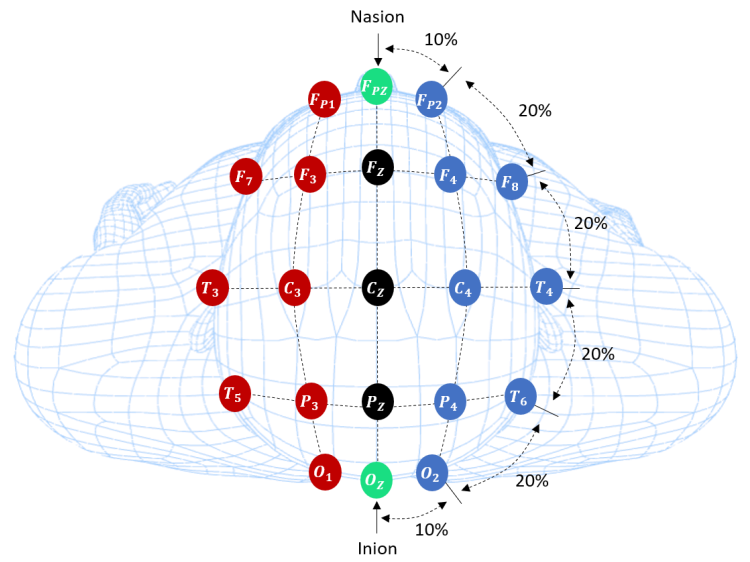

### **1.3. Dataseet Competition IV 2a**

El dataset incluye grabaciones de EEG de diferentes sujetos de Graz University of Technology. Incluye 22 canales de EEG y 3 de EOG para remocion de artifacts, muestreados todos a 250 Hz. Mientras las personas imaginaban 4 diferentes tareas motoras:
- Mano derecha
- Mano Izquierda
- Ambos pies
- Lengua

En el preprocesamiento, las señales fueron filtradas con un filtro pasabanda de 0.5 a 100 Hz y un filtro Notch a 50 Hz. Sensitividad del amplificador a 100 uV. 

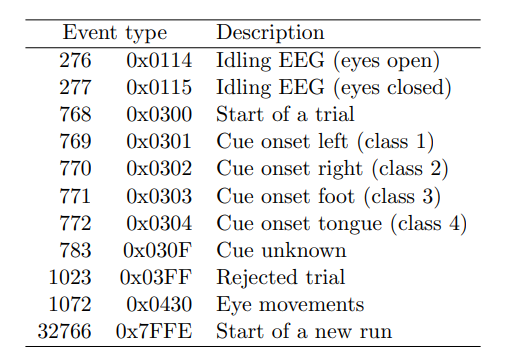

De la tabla, nos fijamos en los eventos 769 (Movimiento de mano izquierda) y 770 (Movimiento de la mano derecha) que son de nuestro interés para el análisis de BCI Motor Imagery del presente proyecto.

### **1.4. Algoritmo FBCSP: *(Training Phase)*** 

*Filter bank*: Aplica un conjunto de filtros pasabandas con frecuencias de corte alternadas (Por ejemplo, aplica de 8 a 12 Hz, de 12 a 16 Hz, de 16 a 20 Hz y sigue asi ...). Es decir, para una sola señal de un electrodo tendras "M" señales filtradas que para nuestro caso será en todo el espectro de las ondas mu y beta.

*Algoritmo CSP*: Algoritmo Common Spatial Pattern, es un algoritmo que filtra espacialmente y comprime la salida a features que representan potencia. Es el puente de unión entre el procesamiento de la señal y el Machine Learning pues nmecesita de entrada a un Aprendizaje de Maquina para poder filtrar espacialmente asignandole mediante diferentes calculos y problemas de autovalores, un peso especial a cada electrodo dependiendo de la distancia a la que se encuentren, en nuestro caso dándolo un mayor peso a C3 y C4 y entre estos mismos eligiendo uno de mayor peso para discriminar entre movimiento de mano derecha o izquierda para el Motor Imagery.

- Movimiento mano derecha ---> ERD en C3 (Corteza motora izquierda) ---> Mayor peso a C3

- Movimiento mano izquierda ---> ERD en C4 (Corteza motora derecha) ---> Mayor peso a C4

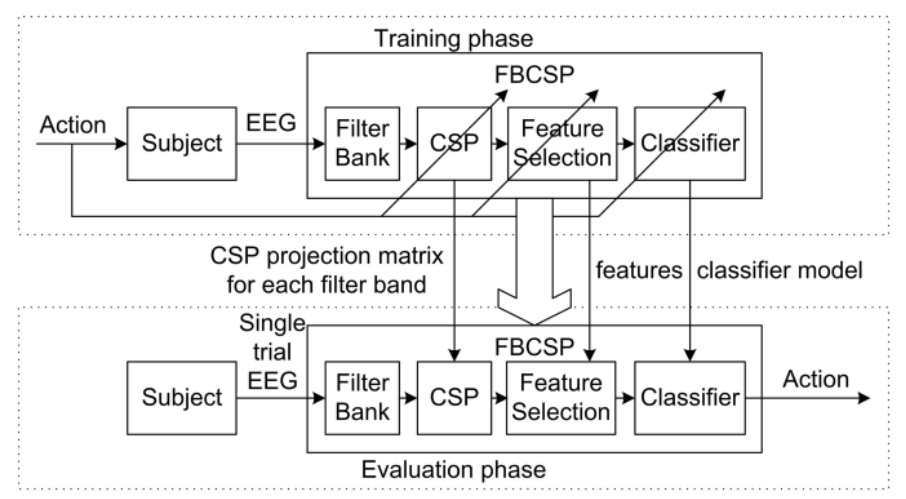

***ERD (Event-Related Desynchronization):*** Es la disminución de la potencia en las bandas mu y beta (activación cortical). Por ejemplo si una persona imagina movimiento en la mano derecha, se da un ERD en C3 y si la imagina en mano izquierda, se da un ERD en C4. Mientras que si la imagina en los pies se da el ERD mas en Cz.

***ERS (Event-Related Synchronization):*** Es el aumento de la potencia en las bandas mu y beta (inactividad o rebote post tarea). Para calcular la potencia de las bandas se usan epochs, que no son mas que intervalos de tiempo escogidos según la actividad motora. 

Para el dataseet competition IV 2a se tiene:
- Fixation cross: [0; 2] seg
- Cue: [2; 3.25] seg
- Motor Imagery: [3; 6] seg
- Break: [6; 8] seg

Links importantes para la programación:

https://www.youtube.com/watch?v=_BdBJOOqMes&list=PLtGXgNsNHqPTgP9wyR8pmy2EuM2ZGHU5Z

https://www.youtube.com/watch?v=Llsfw9RkcIg

https://mne.tools/stable/auto_tutorials/intro/10_overview.html#sphx-glr-auto-tutorials-intro-10-overview-py

Uso de CSP: https://mne.tools/stable/auto_examples/decoding/decoding_csp_eeg.html?utm_source=chatgpt.com

Ejemplo comparativo CSP vs FBCSP: https://moabb.neurotechx.com/docs/auto_examples/advanced_examples/plot_filterbank_csp_vs_csp.html?utm_source=chatgpt.com

Guias:

https://github.com/JGalego/eeg-bci-tutorial/blob/master/eeg_bci.ipynb

https://github.com/amrzhd/EEGNet/blob/main/EEGNet.ipynb




### 1.5. Libreria MNE-Python:

Es la principal librería usada para la extracción de información de los archivos .gdf (formato original del dataseet 2a). Además es usada para el filtrado y el calculo del PSD según bandas

*mne.io.read_raw_gdf ( nombre_de_entrada , eog = Ninguno , misc = Ninguno , stim_channel = ' auto' , exclude = () , include = Ninguno , preload = False , verbose = Ninguno ):* Nos sirve para cargar la señal original 

## **2. Data Understanding**

In [46]:
import numpy as np
import mne # Libreria para análisis de EEG
import matplotlib.pyplot as plt
from mne.filter import filter_data
from mne.decoding import CSP
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc

# Cargamos el archivo GDF del sujeto 1 de entrenamiento del dataseet 2a con mne
ruta = r'F:\IB PUCP - UPCH\7mo Ciclo\Introducción a Señales Biomedicas\Proyecto BCI\Dataseets\BCICIV_2a_gdf\A01T.gdf'
raw = mne.io.read_raw_gdf(ruta, preload = True) 
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right']) # Eliminamos los canales de EOG, quedandonos con los 22 canales EEG

Extracting EDF parameters from F:\IB PUCP - UPCH\7mo Ciclo\Introducción a Señales Biomedicas\Proyecto BCI\Dataseets\BCICIV_2a_gdf\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


c:\Users\dell\anaconda3\envs\BCI-env\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


<RawGDF | A01T.gdf, 22 x 672528 (2690.1 s), ~112.9 MiB, data loaded>

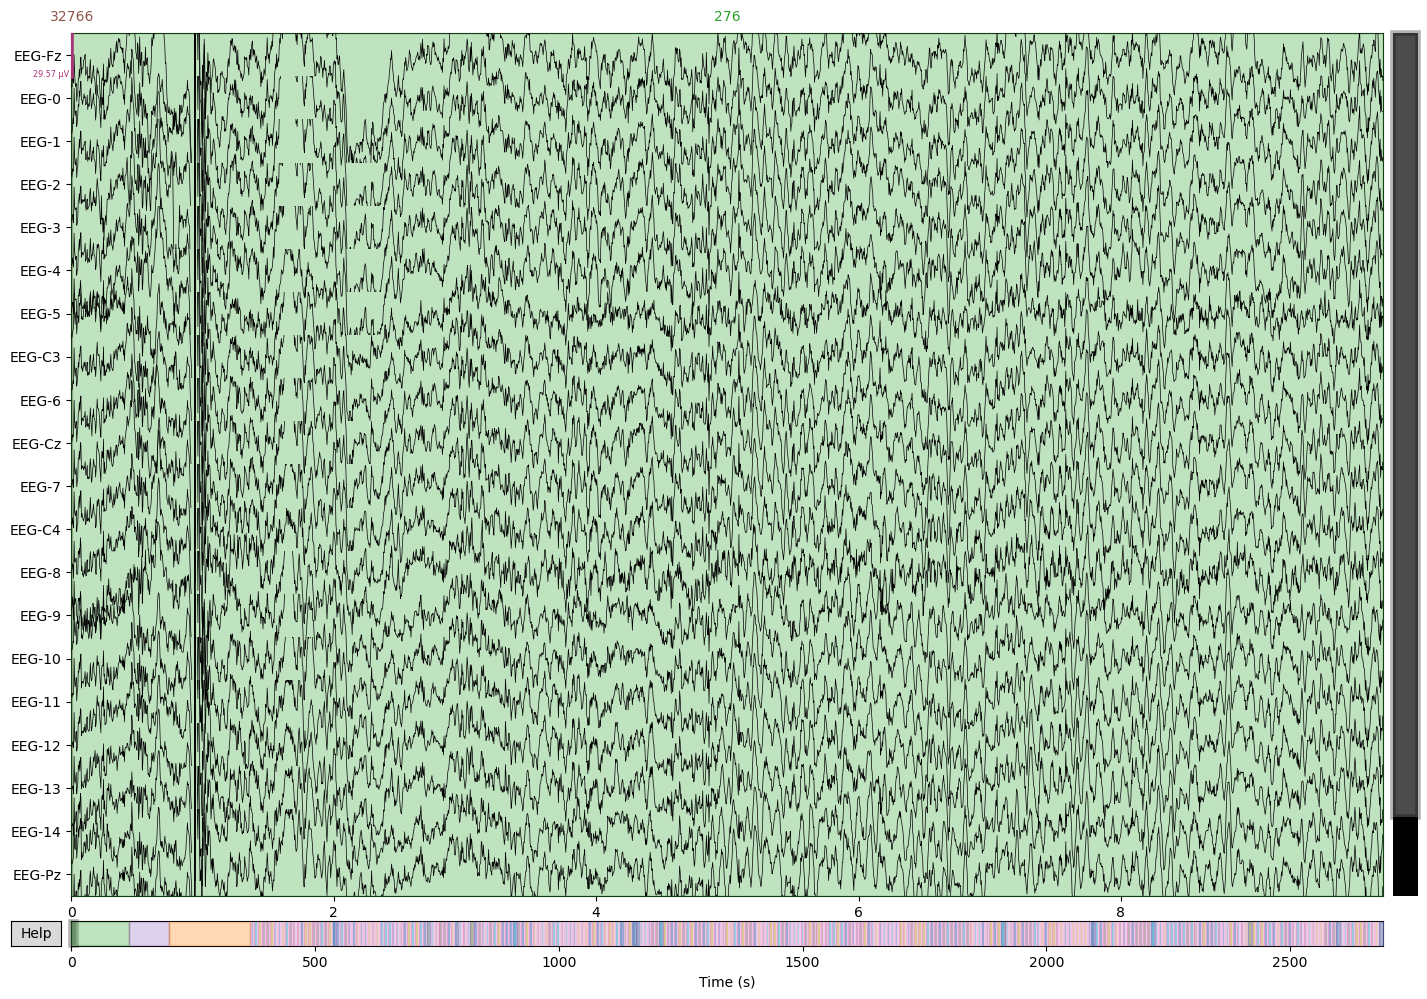

In [47]:
# Grafica de las señales EEG
fig = raw.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)
plt.show()

De la gráfica para visualización podemos destacar el tamaño del dataseet, son aproximadamente 2700 segundos de grabacion, realizados para 22 canales (en la gráfica solo se observan 20 de los 22 pues omite los ultimos 2). Donde aproximadamente a los 250 segundos se observa una gran amplitud en todas las señales debido a que es en este tiempo en el que empiezan los trials de nuestro interes (antes de este tiempo se evaluaban las señales EOG que no son de nuestro interes).

In [48]:
events = mne.events_from_annotations(raw) # Extraemos los eventos de las anotaciones del archivo GDF
events # Imprimimos los eventos
# Como se puede ver, según la documentación del dataseet 2a, son un total de 10 eventos por lo que procedemos a crear un 
# diccionario con todos los eventos y su respectivo significado

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


(array([[     0,      0,      5],
        [     0,      0,      3],
        [ 29683,      0,      5],
        ...,
        [670550,      0,      6],
        [670550,      0,      1],
        [671050,      0,      7]]),
 {'1023': 1,
  '1072': 2,
  '276': 3,
  '277': 4,
  '32766': 5,
  '768': 6,
  '769': 7,
  '770': 8,
  '771': 9,
  '772': 10})

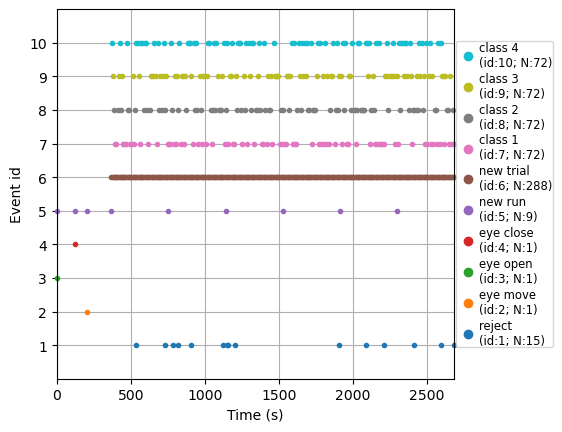

In [49]:
event_dict = {
    'reject': 1, 
    'eye move': 2, # No lo necesitamos
    'eye open': 3, # No lo necesitamos
    'eye close': 4, # No lo necesitamos
    'new run': 5,
    'new trial': 6,
    'class 1': 7, # Movimiento de mano izquierda
    'class 2': 8, # Movimiento de mano derecha
    'class 3': 9, # Movimiento de ambos pies
    'class 4': 10, # Movimiento de lengua
}
# Visualizamos los eventos
fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)


Aca podemos visualizar los eventos en el tiempo y su respectivo ID unicamente para el sujeto 1 de entrenamiento del dataseet 2a.
 - *New Run y EOG:* Se dividio el experimento en 6 en 9 entrenamientos (new run) de los cuales los 3 primeros son descartables pues se usaron para EOG y los 6 restantes son los que contienen los eventos de motor imagery.
 
 - *New Trial:* Un trial es el ensayo de motor imagery que dura aproximadamente 7.5 segundos (El sujeto mira una cruz fija de 0 a 2 seg, luego aparece el cue/flecha de 2 a 3.5 seg y se da la imaginación motora de 3 a 6 seg. Dándose finalmente un break de 6 a 7.5 seg) 

 - *Classes:* Nos centraremos en estos apartados, en las clases 1 *(Imaginación motora de mano izquierda)* y 2 *(Imaginación motora de mano derecha)*
 
 - *Duración de entrenamiento:* Aproximadamente 2880 segundos

In [ ]:
epoch = mne.Epochs(raw, events=events[0], event_id=[7,8], tmin = 0, tmax = 4, baseline=None) # Creamos los epochs de 3 segundos para Motor Imagery de mano izquierda y derecha
epoch.get_data().shape # (n_epochs, n_channels, n_times) = (144, 22, 751)

Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 1001 original time points ...
0 bad epochs dropped


(144, 22, 1001)

Acá podemos visualizar que en son 144 trials (72 para MI de mano derecha y 72 para MI de mano izquierda). Tambien el numero de canales que es 22 y 176 que corresponde al numero de muestras por trial. Como se tiene un muestreo a 250 Hz. Podemos entonces notar que la duración del trial es de 176/250 = 0.704

In [51]:
labels = epoch.events[:, -1] -7 # Seleccionamos la ultima columna de la matriz de eventos que tenia 3 columnas
labels # 0 = Movimiento de mano izquierda, 1 = Movimiento de mano derecha

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0])

*Evoked Potentials:* Son los potenciales evocados, señales obtenidas al promediar varios epochs (trials) alineados a un mismo tipo de evento. Eliminan ruido no relacionado al promediarse y lo usamos para ver como responde el cerebro a estimulos motores.

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


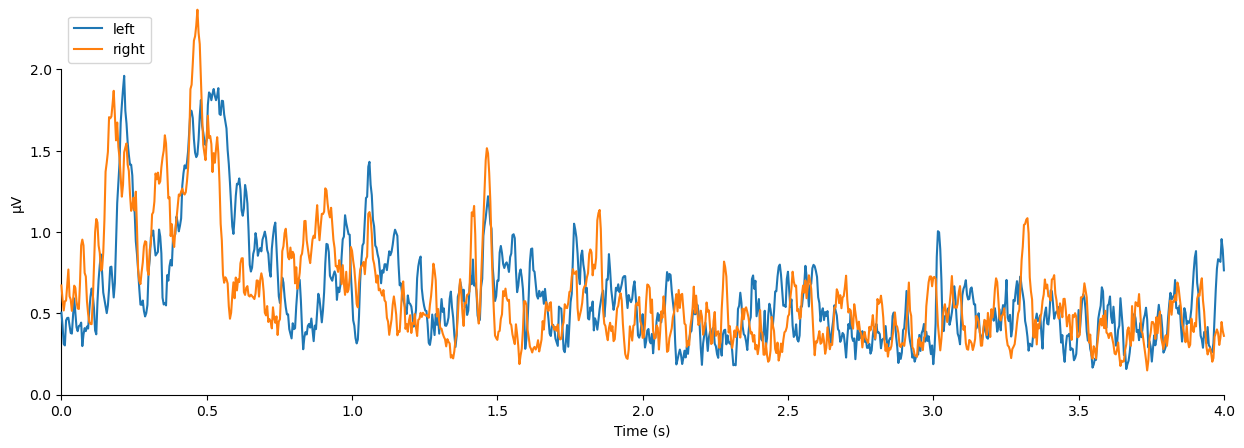

[<Figure size 1500x500 with 1 Axes>]

In [52]:
evoked_left = epoch['7'].average() # Promedio de todos los epochs de MI de mano izquierda
evoked_right = epoch['8'].average() # Promedio de todos los epochs de MI de mano derecha
dicts = {'left': evoked_left, 'right': evoked_right}
fig, ax = plt.subplots(figsize=(15, 5))  # ancho=10, alto=5
mne.viz.plot_compare_evokeds(dicts, axes=ax, show=True)

En la figura se visualiza el promedio de la señal EEG de todos los canales para el epoch (la imaginacion motora del trial que dura de 0 a 3 segundos).

In [53]:
features = epoch.get_data() # Extraemos los datos de los epochs en un array 3D (n_epochs, n_channels, n_times)
# Labels nos muestra el numero de trials 
# Features es un array 3D (n_epochs, n_channels, n_times), donde n_epochs es el numero de trials, n_channels es el numero de canales (22) y n_times es el numero de muestras por trial (202)
labels.shape, features.shape 

Using data from preloaded Raw for 144 events and 1001 original time points ...


((144,), (144, 22, 1001))

In [54]:
print(features[0]) # Selecciona el primer trial (Un arreglo 2D de 22 canales como filas y 202 muestras como columnas)

[[ 1.96777344e-05  1.78710938e-05  1.66503906e-05 ... -2.92968750e-07
   8.78906250e-07  4.49218750e-06]
 [ 1.86035156e-05  1.30371094e-05  1.38671875e-05 ... -3.41796875e-07
  -1.95312500e-07  3.32031250e-06]
 [ 2.01660156e-05  1.74804687e-05  1.66015625e-05 ...  3.80859375e-06
   1.85546875e-06  5.81054687e-06]
 ...
 [ 1.91894531e-05  1.12792969e-05  9.17968750e-06 ...  2.78320312e-06
   7.81250000e-07  4.93164062e-06]
 [ 1.45996094e-05  6.83593750e-06  6.00585938e-06 ...  3.22265625e-06
   1.36718750e-06  6.15234375e-06]
 [ 2.08496094e-05  1.30371094e-05  1.13769531e-05 ...  8.78906250e-07
  -2.92968750e-06  3.41796875e-07]]


In [55]:
print(epoch[0]) 

<Epochs | 1 events (all good), 0 – 4 s (baseline off), ~22 KiB, data not loaded,
 '8': 1>


In [56]:
# Mostramos el primer trial para una mejor visualizacion
fig = epoch[0].plot(n_channels=22,scalings='auto',title='Trial 0 - 22 canales', show=False)
fig.set_size_inches(15, 10)
fig.show()

Using data from preloaded Raw for 1 events and 1001 original time points ...
Using data from preloaded Raw for 1 events and 1001 original time points ...


C:\Users\dell\AppData\Local\Temp\ipykernel_7152\3601878336.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


En la grafica se visualiza lo que es un trial de 0 a 3 segundos de duracion (El tiempo en el que se da la imaginación motora que era del 3er al 6to segundo de cada trial).

In [57]:
# Creamos el banco de filtros para las bandas de frecuencia de interés (mu: 8-13 Hz, beta: 13-30 Hz)
filtered_mu = filter_data(features, sfreq=250, l_freq=8, h_freq=13)
filtered_beta = filter_data(features, sfreq=250, l_freq=13, h_freq=30)

Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 413 samples (1.652 s)

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- F

Como el dataseet competition IV 2a son 22 canales y un total de 750 muestras en el tiempo (3 segundos a 250 Hz) por trial, son 16500 numeros para describir un solo trial, como tenemos 144 (72 de mano derecha y 72 de mano izquierda), lograr meter todo esto directamente al Machine Learning es ineficiente y de mucho costo computacional. El algoritmo CSP lo que hace es resumir estos 16500 numeros a tan solo 8 numeros que describen cada trial (La cantidad de numeros es ajustable por cada caso, en el presente avance usare solo 8, 4 para banda mu y 4 para banda beta). Estos numeros representan que tanta energia tiene el patron del trial, en realidad CSP bota un numero que representa la energia por cada canal, pero solo usaremos los 4 mas relevantes para Motor Imagery, es decir la energia en C3, C4 principalmente.

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


c:\Users\dell\anaconda3\envs\BCI-env\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


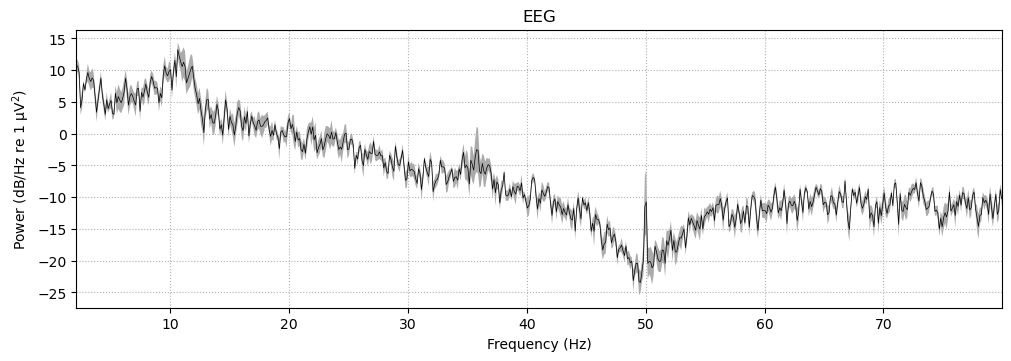

In [58]:
raw.plot_psd(
    tmin=0, tmax=60,  # rango de tiempo a visualizar
    fmin=2, fmax=80,  # rango de frecuencias
    average=True,     # promedio de canales
    spatial_colors=False
)

Aca se muestra un aspecto general de la potencia en toda la señal sin filtrar, no por trials, por lo que no es certero para realizar un análisis de clasificación. Sin embargo, podemos apreciar generalidades como que hay un pico a 50 Hz que viene a ser el ruido por intereferencia eléctrica y picos predominantes de mayor potencia en el rango de 8 a 13 Hz que es la banda alpha o mu, destacanda que esta banda es la que mas participa en la imaginación motora.

Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


c:\Users\dell\anaconda3\envs\BCI-env\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


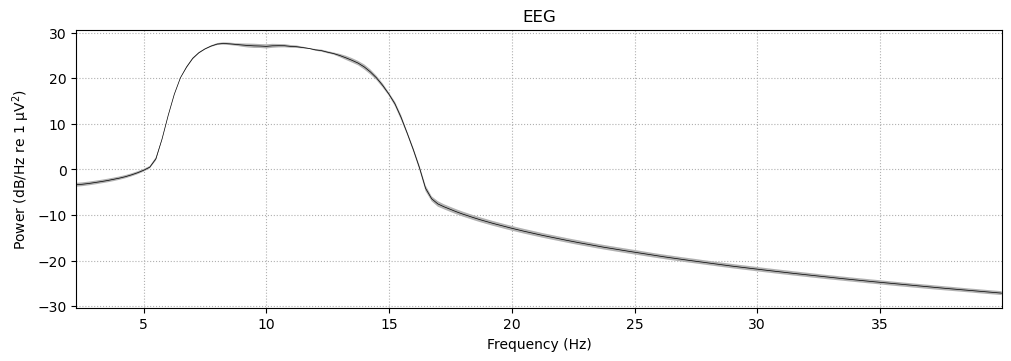

In [59]:
info = epoch.info  # reutilizamos la info del original
epochs_mu = mne.EpochsArray(filtered_mu, info, events=epoch.events, event_id=epoch.event_id)
epochs_beta = mne.EpochsArray(filtered_beta, info, events=epoch.events, event_id=epoch.event_id)

# PSD promedio de todos los trials en banda alpha
epochs_mu.compute_psd(fmin=2, fmax=40).plot(average=True, picks=['EEG-C3','EEG-C4'])

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


c:\Users\dell\anaconda3\envs\BCI-env\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


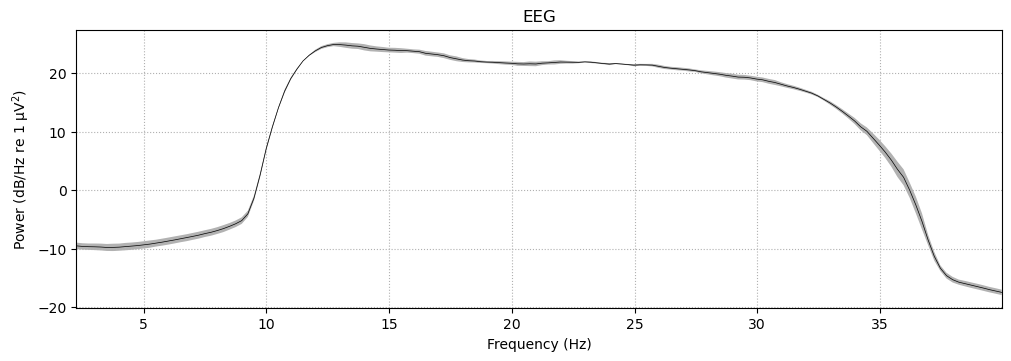

In [60]:
# PSD promedio de todos los trials en banda beta
epochs_beta.compute_psd(fmin=2, fmax=40).plot(average=True, picks=['EEG-C3','EEG-C4'])

Estas 2 ultimas graficas solo nos sirven para corroborar un filtrado temporal correcto, pues muestran el promedio del psd de todos los trials por lo que no podemos diferenciar entre movimiento de mano izquierda o derecha. Sin embargo, a continuación nos enfocaremos en el primer trial y trataremos de ver segun su psd si es movimiento de mano izquierda o derecha.

In [61]:
# Separacion de epochs por clase
epochs_left  = epoch['7']   # Mano izquierda
epochs_right = epoch['8']   # Mano derecha
print(epochs_left)
print(epochs_right)

<Epochs | 72 events (all good), 0 – 4 s (baseline off), ~22 KiB, data not loaded,
 '7': 72>
<Epochs | 72 events (all good), 0 – 4 s (baseline off), ~22 KiB, data not loaded,
 '8': 72>


Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)
Effective window size : 1.024 (s)


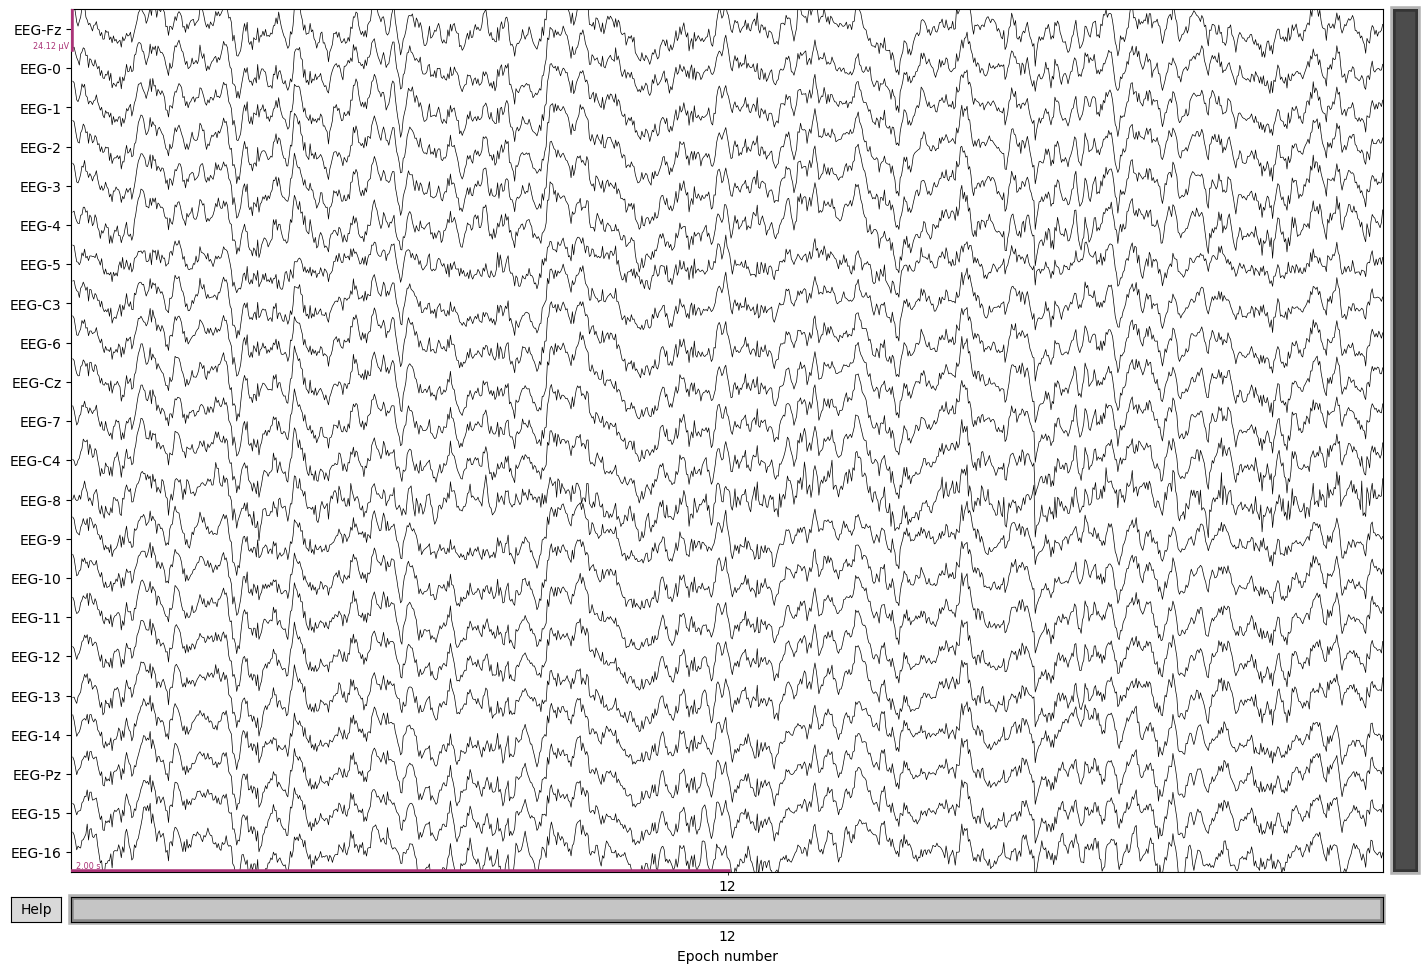

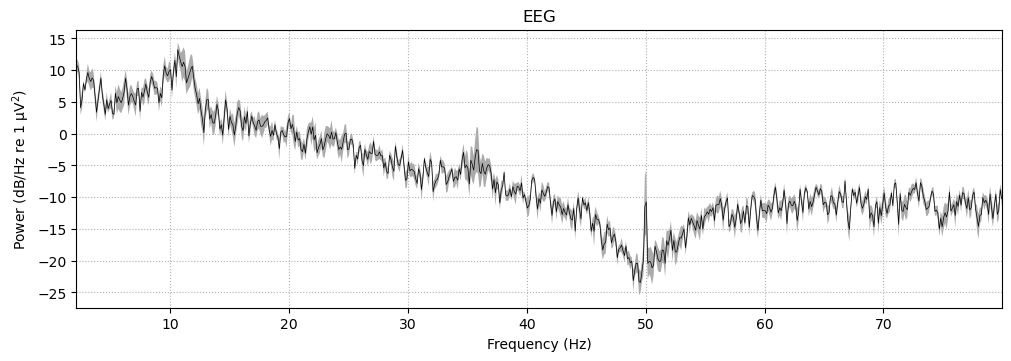

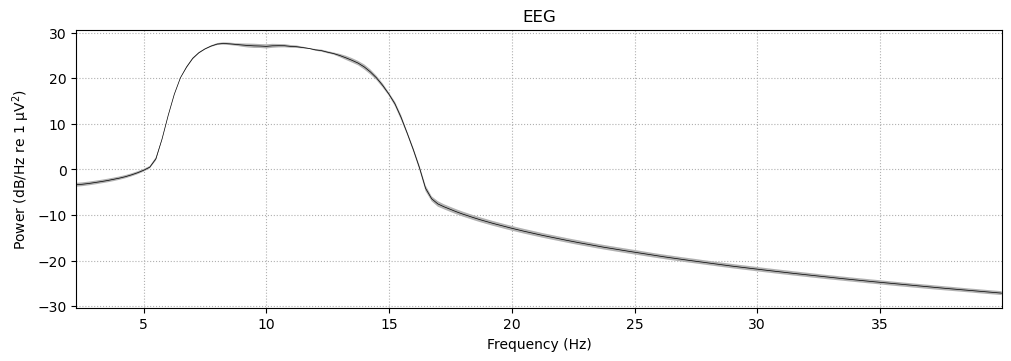

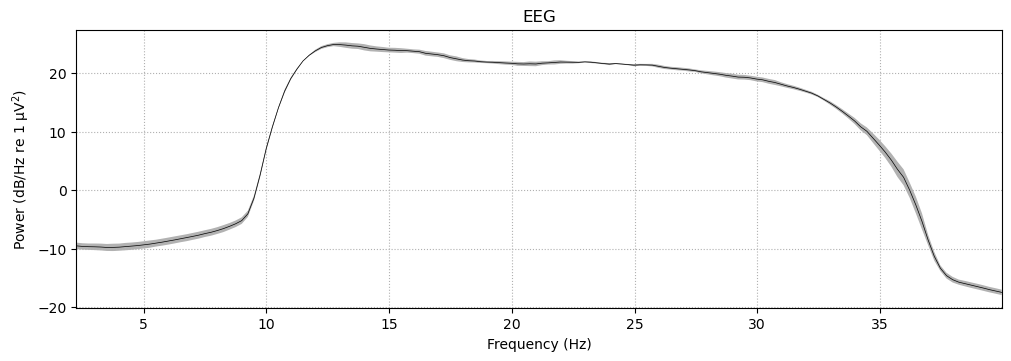

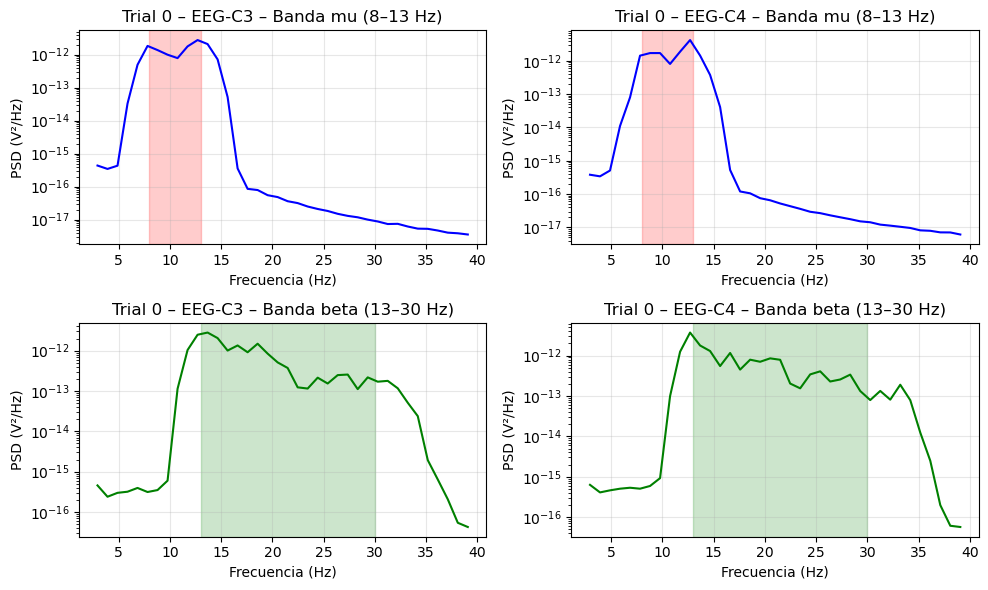

In [62]:
trial_idx = 0 # Indice del trial a analizar
trial_mu = filtered_mu[trial_idx]
trial_beta = filtered_beta[trial_idx]
sfreq = 250  # Frecuencia de muestreo
channels = ['EEG-C3', 'EEG-C4'] # Canales de interés, para MI de manos son C3 y C4
ch_idx = [epoch.ch_names.index(ch) for ch in channels]

# ----------------------------
# Función para PSD con MNE
# ----------------------------
from mne.time_frequency import psd_array_welch

def compute_psd_band(trial_data, sfreq, picks, fmin=2, fmax=40):
    psd, freqs = psd_array_welch(trial_data[picks], sfreq=sfreq,
                                 fmin=fmin, fmax=fmax, n_fft=256)
    return psd.squeeze(), freqs

# ----------------------------
# Calcular y plotear
# ----------------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

# Mu-band
for i, ch in enumerate(ch_idx):
    psd, freqs = compute_psd_band(trial_mu, sfreq, ch)
    axes[i].semilogy(freqs, psd, color='blue')
    axes[i].set_title(f"Trial {trial_idx} – {channels[i]} – Banda mu (8–13 Hz)")
    axes[i].set_xlabel("Frecuencia (Hz)")
    axes[i].set_ylabel("PSD (V²/Hz)")
    axes[i].grid(True, alpha=0.3)
    axes[i].axvspan(8, 13, color='red', alpha=0.2)

# Beta-band
for i, ch in enumerate(ch_idx):
    psd, freqs = compute_psd_band(trial_beta, sfreq, ch)
    axes[i+2].semilogy(freqs, psd, color='green')
    axes[i+2].set_title(f"Trial {trial_idx} – {channels[i]} – Banda beta (13–30 Hz)")
    axes[i+2].set_xlabel("Frecuencia (Hz)")
    axes[i+2].set_ylabel("PSD (V²/Hz)")
    axes[i+2].grid(True, alpha=0.3)
    axes[i+2].axvspan(13, 30, color='green', alpha=0.2)

plt.tight_layout()
plt.show()

### *Clasificacion y entrenamiento del algoritmo CSP:*

In [63]:
# Kfold es un metodo de evaluacion cruzada con CSP y LDA, parte los datos n_splits = 10 (divide los trials en 10 partes)
# 9 son usadas para entrenar el modelo y 1 para evaluarlo, repitiendo este proceso 10 veces. Obteniendo 10 accuracys que 
# se promedian, shuffle = True para mezclar los datos al azar antes de dividirlos en pliegues, random_state = 42 es una 
# semilla que evita la aleatoriedad al volver a correr el codigo.
cv = KFold(n_splits=10, shuffle=True, random_state=42)
epochs_data = 1e6 * epoch.get_data() # Escalamos los datos a microvoltios
# Assemble a classifier
lda = LinearDiscriminantAnalysis()

Using data from preloaded Raw for 144 events and 1001 original time points ...


In [64]:
# Aplicamos el algoritmo CSP para extraer características discriminativas entre las dos clases (mano izquierda y mano derecha)
csp_mu = CSP(n_components=4, reg=None, log=True, norm_trace=False, cov_est='epoch')
X_csp_mu = csp_mu.fit_transform(filtered_mu, labels)
csp_beta = CSP(n_components=4, reg=None, log=True, norm_trace=False, cov_est='epoch')
X_csp_beta = csp_beta.fit_transform(filtered_beta, labels)
print(X_csp_mu)
print(X_csp_beta)

Computing rank from data with rank=None
    Using tolerance 3.1e-05 (2.2e-16 eps * 22 dim * 6.3e+09  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Estimating class=0 covariance (average over epochs; EMPIRICAL)
Estimating class=1 covariance (average over epochs; EMPIRICAL)
Computing rank from data with rank=None
    Using tolerance 3e-05 (2.2e-16 eps * 22 dim * 6.1e+09  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Estimating class=0 covariance (average over epochs; EMPIRICAL)
Estimating class=1 covariance (average over epochs; EMPIRICAL)
[[-1.61411403e+00 -7.67928985e-01 -9.21252915e-01 -9.11265949e-01]
 [ 6.12549916e-01  6.27776091e-01 -9.99964909e-01 -1.06879982e+00]
 [ 5.88200764e-01  5.79819101e-01 -8.49397286e-01 -1.09481643e+00]
 [-7.80946681e-01 -7.92694357e-01 -4.98243803e-01 -1.13601650e+00]
 [-1.31393411e+00 -9.91617380e-01 -2.68022534e

In [65]:
print(csp_mu.patterns_.shape)   # (n_components, n_channels)
print(csp_mu.patterns_[0])      # pesos del primer componente en los 22 canales

(22, 22)
[-1.45332924e-06 -1.27173092e-06 -1.33337448e-06 -1.34258755e-06
 -9.73784852e-07 -7.92830179e-07  6.11375437e-07  3.74739873e-07
 -2.19447907e-07 -6.17773576e-07 -4.79534465e-07 -3.66660472e-07
 -2.81229701e-07  1.98326023e-06  1.16854396e-06  5.53233951e-07
  2.07899643e-07  1.12054118e-07  1.92859400e-06  1.28370628e-06
  8.07681296e-07  1.39725037e-06]


In [66]:
# Concatenamos las características de ambas bandas 
X_features = np.concatenate([X_csp_mu, X_csp_beta], axis=1)
print(X_features)
print("Features finales:", X_features.shape)  # (n_trials, 8)
# Esto nos da un total de 8 características por trial (4 de la banda mu y 4 de la banda beta)


[[-1.61411403 -0.76792899 -0.92125292 ... -0.62852758 -0.68072169
  -0.20947718]
 [ 0.61254992  0.62777609 -0.99996491 ... -0.95293303  0.13477533
  -0.87044187]
 [ 0.58820076  0.5798191  -0.84939729 ... -0.45965831  0.19486729
  -0.57702849]
 ...
 [-0.346504   -0.5546706  -0.58162799 ... -0.85179052 -0.50073581
  -0.11045987]
 [-2.20479587 -1.3467485  -1.50104173 ... -0.70792076 -1.34568915
  -0.40225867]
 [-0.49891237 -0.58286145 -1.36810321 ... -0.97482141 -0.63721046
  -1.18895658]]
Features finales: (144, 8)


In [67]:
# 
scores = cross_val_score(lda, X_features, labels, cv=cv, n_jobs=1)
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("CSP + LDA Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
print("Accuracy promedio: %.3f ± %.3f" % (scores.mean(), scores.std()))

CSP + LDA Classification accuracy: 0.917143 / Chance level: 0.500000
Accuracy promedio: 0.917 ± 0.041


In [68]:
print(scores)              # ver accuracies de cada fold
print(scores.mean(), scores.std())  # promedio y dispersión

[0.86666667 0.93333333 0.93333333 0.86666667 1.         0.92857143
 0.92857143 0.92857143 0.85714286 0.92857143]
0.9171428571428573 0.04075255789587556


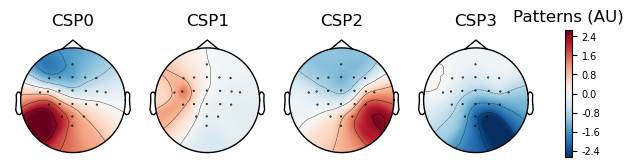

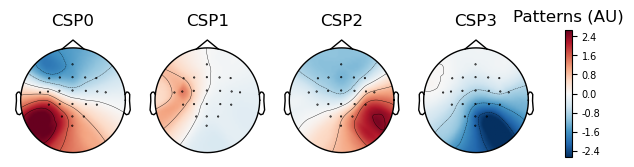

In [69]:
# Asignar montage estándar 10-20
rename_dict = {
    'EEG-Fz': 'Fz',
    'EEG-0': 'FC3',
    'EEG-1': 'FC1',
    'EEG-2': 'FCz',
    'EEG-3': 'FC2',
    'EEG-4': 'FC4',
    'EEG-5': 'C5',
    'EEG-C3': 'C3',
    'EEG-6': 'C1',
    'EEG-Cz': 'Cz',
    'EEG-7': 'C2',
    'EEG-C4': 'C4',
    'EEG-8': 'C6',
    'EEG-9': 'CP3',
    'EEG-10': 'CP1',
    'EEG-11': 'CPz',
    'EEG-12': 'CP2',
    'EEG-13': 'CP4',
    'EEG-14': 'P1',
    'EEG-Pz': 'Pz',
    'EEG-15': 'P2',
    'EEG-16': 'POz'
}
epoch.rename_channels(rename_dict) # Cambiamos los nombres de los canales para que coincidan con el estándar 10-20
montage = mne.channels.make_standard_montage('standard_1020')
epoch.set_montage(montage) # Cambiamos el montage de los canales 
csp_mu.plot_patterns(epoch.info, ch_type='eeg', units='Patterns (AU)')

La figura que se muestra es un mapa topografico de los 4 componentes de CSP provenientes del feature extraction que muestran las zonas de los electrodos en el cuero cabelludo que deben tener mayor peso para separar movimiento de MI mano derecha vs mano izquierda. Estos son los patrones espaciales que el algoritmo aprendio en base a nuestros 144 trials con un acuraccy del 92.4286%.
CSP0 y CSP1 buscan maximinar la varianza para el movimiento de mano derecha. Mientras que CSP2 y CSP3 maximizan la varianza para el movimiento de mano izquierda 

*Zona roja --> Mayor peso de los electrodos*

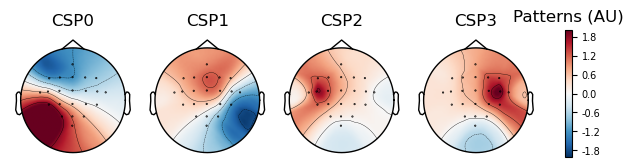

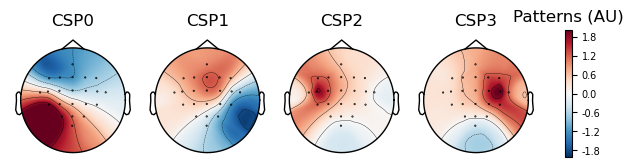

In [70]:
csp_beta.plot_patterns(epoch.info, ch_type='eeg', units='Patterns (AU)')

La figura mostrada es una topografia del cuero cabelludo igual al anterior pero ahora para la banda beta

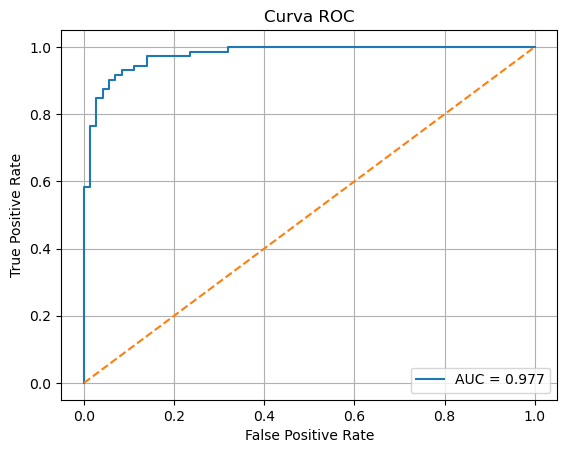

In [71]:
proba = cross_val_predict(lda, X_features, labels, cv=cv, method='predict_proba')
fpr, tpr, thr = roc_curve(labels, proba[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()

El modelo presenta una curva ROC ideal pues la curva sube rapido hacia la esquina superior izquierda, el modelo esta distinguiendo bien entre imaginación motora de mano derecha e izquierda. Con un valor AUC cercano a 1 nos indica un buen clasificador

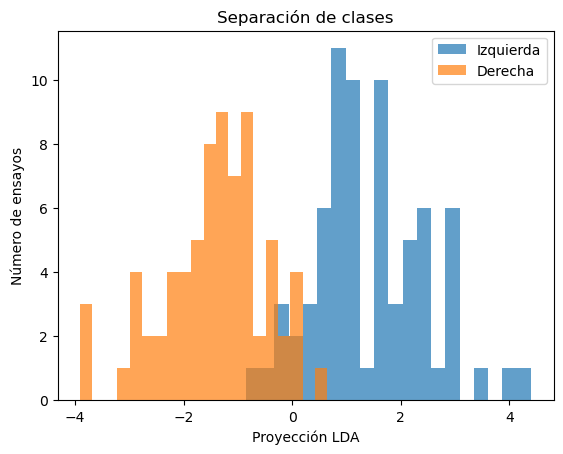

In [72]:
X_lda = lda.fit_transform(X_features, labels)
plt.hist(X_lda[labels==0], bins=20, alpha=0.7, label='Izquierda')
plt.hist(X_lda[labels==1], bins=20, alpha=0.7, label='Derecha')
plt.xlabel("Proyección LDA")
plt.ylabel("Número de ensayos")
plt.title("Separación de clases")
plt.legend()
plt.show()

Using data from preloaded Raw for 144 events and 1001 original time points ...
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-12 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 14.62 Hz)
- Filter length: 413 samples (1.652 s)

Effective window size : 4.004 (s)
Effective window size : 4.004 (s)


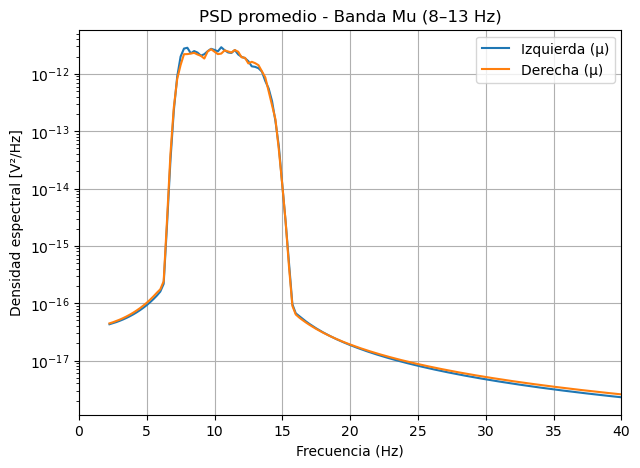

In [97]:
epoch.load_data()
epochs_mu = epoch.copy().filter(l_freq=8., h_freq=13., fir_design='firwin', phase='zero-double')

epochs_mu_left = epochs_mu[labels == 0]
epochs_mu_right = epochs_mu[labels == 1]

psd_mu_left = epochs_mu_left.compute_psd(fmin=2, fmax=40, method='welch')
psd_mu_right = epochs_mu_right.compute_psd(fmin=2, fmax=40, method='welch')

f_mu = psd_mu_left.freqs
psd_mu_left_mean = psd_mu_left.get_data().mean(axis=0).mean(axis=0)
psd_mu_right_mean = psd_mu_right.get_data().mean(axis=0).mean(axis=0)

plt.figure(figsize=(7,5))
plt.semilogy(f_mu, psd_mu_left_mean, label='Izquierda (μ)', color='tab:blue')
plt.semilogy(f_mu, psd_mu_right_mean, label='Derecha (μ)', color='tab:orange')
plt.title('PSD promedio - Banda Mu (8–13 Hz)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad espectral [V²/Hz]')
plt.xlim(0, 40)
plt.legend()
plt.grid(True)
plt.show()

Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 255 samples (1.020 s)

Effective window size : 4.004 (s)
Effective window size : 4.004 (s)


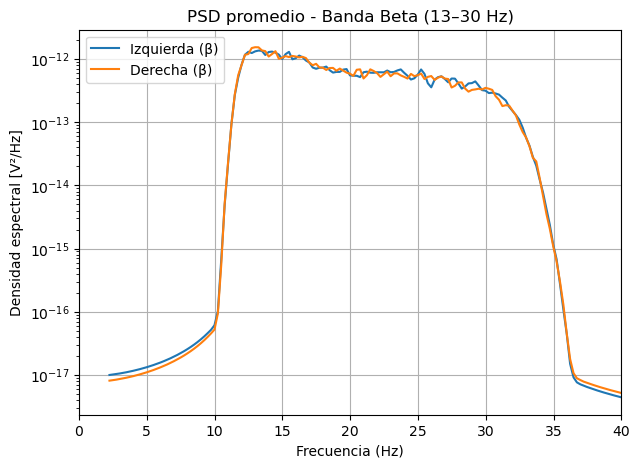

In [100]:
epochs_beta = epoch.copy().filter(l_freq=13., h_freq=30., fir_design='firwin', phase='zero-double')

epochs_beta_left = epochs_beta[labels == 0]
epochs_beta_right = epochs_beta[labels == 1]

psd_beta_left = epochs_beta_left.compute_psd(fmin=2, fmax=40, method='welch')
psd_beta_right = epochs_beta_right.compute_psd(fmin=2, fmax=40, method='welch')

f_beta = psd_beta_left.freqs
psd_beta_left_mean = psd_beta_left.get_data().mean(axis=0).mean(axis=0)
psd_beta_right_mean = psd_beta_right.get_data().mean(axis=0).mean(axis=0)

plt.figure(figsize=(7,5))
plt.semilogy(f_beta, psd_beta_left_mean, label='Izquierda (β)', color='tab:blue')
plt.semilogy(f_beta, psd_beta_right_mean, label='Derecha (β)', color='tab:orange')
plt.title('PSD promedio - Banda Beta (13–30 Hz)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad espectral [V²/Hz]')
plt.xlim(0, 40)
plt.legend()
plt.grid(True)
plt.show()

No hay gran diferencia entre el psd para mano derecha y el psd para mano izquierda, pues estos graficos se han creado sin realizar el filtrado espacial supervisado. Al realizar el CSP deberiamos maximizar esta diferencia.

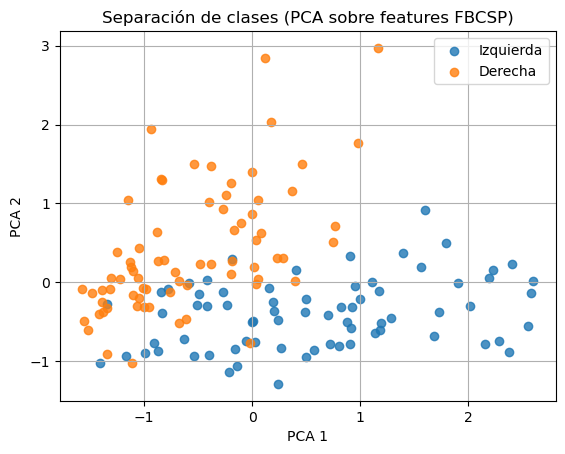

In [104]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_features)

plt.figure()
plt.scatter(X_pca[labels==0, 0], X_pca[labels==0, 1], label='Izquierda', alpha=0.8)
plt.scatter(X_pca[labels==1, 0], X_pca[labels==1, 1], label='Derecha', alpha=0.8)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Separación de clases (PCA sobre features FBCSP)")
plt.legend()
plt.grid(True)
plt.show()